In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch

from utils import *
from models import MatrixFactorization, NCF
from datasets import MovieLens

In [2]:
np.random.seed(42)

# First tutorial
Mostly following [this](https://www.ethanrosenthal.com/2017/06/20/matrix-factorization-in-pytorch/)

Another of other resources:

[NCF model for ranked](https://towardsdatascience.com/recommender-systems-using-deep-learning-in-pytorch-from-scratch-f661b8f391d7)

[Another, slightly too comp,licated NCF model for ranked](https://medium.com/@iliazaitsev/how-to-implement-a-recommendation-system-with-deep-learning-and-pytorch-2d40476590f9)

## Load Data

In [3]:
data = MovieLens('data/raw/ml-latest-small/ratings.csv')
movies = pd.read_csv('data/raw/ml-latest-small/movies.csv')

# data = MovieLens('data/raw/ml-100k/u.data', 
#                 data_kwargs={'sep':'\t', 
#                              'names': ['userId', 'movieId', 'rating', 'timestamp']}
#                )
data_stats = data.get_stats()

## Build model

Two models: Matrix Factorization and NCF.

In [4]:
MF_model = MatrixFactorization(data_stats['n_users'], data_stats['n_items'], 
                            n_factors=50, bias=True, y_range=(0,5))
NCF_model = NCF(data_stats['n_users'], data_stats['n_items'],
               n_factors=50, y_range=(0,5))
loss_fun = torch.nn.MSELoss()
MF_opt = torch.optim.AdamW(MF_model.parameters(), lr=.001, 
                                    weight_decay=2e-4)
NCF_opt = torch.optim.AdamW(NCF_model.parameters(), lr=.001, 
                                    weight_decay=2e-4)
MF_history = None
NCF_history = None

## Train

In [5]:
MF_history = train(MF_model, data, loss_fun, MF_opt, n_epochs=5, 
                print_epochs=1, history=MF_history)

[Epoch 1] loss: 1.465 validation loss: 0.922
[Epoch 2] loss: 0.751 validation loss: 0.765
[Epoch 3] loss: 0.566 validation loss: 0.735
[Epoch 4] loss: 0.429 validation loss: 0.731
[Epoch 5] loss: 0.326 validation loss: 0.741


In [6]:
NCF_history = train(NCF_model, data, loss_fun, NCF_opt, n_epochs=15, 
                print_epochs=1, history=NCF_history)

[Epoch 1] loss: 1.033 validation loss: 0.910
[Epoch 2] loss: 0.917 validation loss: 0.863
[Epoch 3] loss: 0.859 validation loss: 0.827
[Epoch 4] loss: 0.810 validation loss: 0.801
[Epoch 5] loss: 0.772 validation loss: 0.783
[Epoch 6] loss: 0.746 validation loss: 0.772
[Epoch 7] loss: 0.726 validation loss: 0.766
[Epoch 8] loss: 0.710 validation loss: 0.758
[Epoch 9] loss: 0.695 validation loss: 0.760
[Epoch 10] loss: 0.685 validation loss: 0.756
[Epoch 11] loss: 0.677 validation loss: 0.751
[Epoch 12] loss: 0.669 validation loss: 0.754
[Epoch 13] loss: 0.665 validation loss: 0.754
[Epoch 14] loss: 0.657 validation loss: 0.757
[Epoch 15] loss: 0.652 validation loss: 0.750


## Look at training curve

In [7]:
history = NCF_history # MF_history
model = NCF_model # MF_model

Text(0, 0.5, 'MSE')

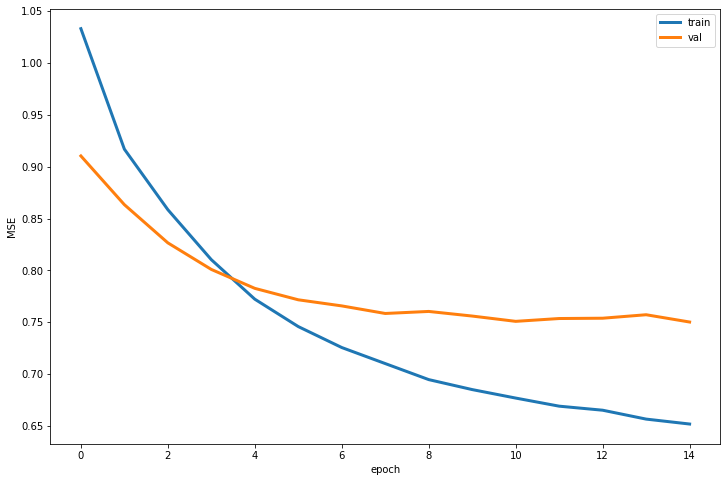

In [8]:
plt.figure(figsize=(12,8))
plt.plot([i['train_loss'] for i in history], lw=3, label='train')
plt.plot([i['val_loss'] for i in history], lw=3, label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE')

## Final Evaluation

In [9]:
corr = lambda pred, true: np.corrcoef(pred, true)[1,0]
MSE = lambda pred, true: torch.nn.MSELoss()(pred, true).item()
metric_funs = {'correlation': corr,
              'MSE': MSE}
metrics = evaluate(model, data, metric_funs)

### Training data

Text(0.1, 0.2, 'MSE: 0.59')

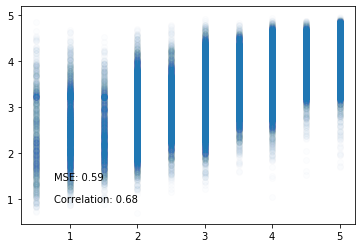

In [10]:
yhat, y = get_pred_true(model, data, 'train')
plt.scatter(y, yhat.detach(), alpha=.01)
ax = plt.gca()
plt.text(.1,.1,
         "Correlation: %s" % metrics['train_correlation'].round(2),
         transform=ax.transAxes)
plt.text(.1,.2,
         "MSE: %s" % np.round(metrics['train_MSE'],2),
         transform=ax.transAxes)

### Validation data

Text(0.1, 0.2, 'MSE: 0.75')

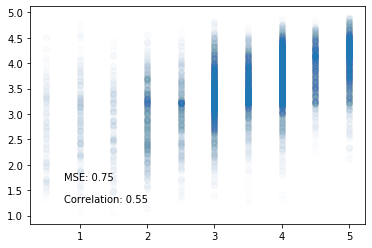

In [11]:
yhat, y = get_pred_true(model, data, 'val')
plt.scatter(y, yhat.detach(), alpha=.01)
ax = plt.gca()
plt.text(.1,.1,
         "Correlation: %s" % metrics['val_correlation'].round(2),
         transform=ax.transAxes)
plt.text(.1,.2,
         "MSE: %s" % np.round(metrics['val_MSE'],2),
         transform=ax.transAxes)

## Embedding Evaluation

In [12]:
import pandas as pd
movies.index = movies.movieId

In [13]:
item_embeddings = model.item_embedding.weight.detach().numpy()
reverse_map = {v:k for k,v in data.itemIdmap.items()}

In [14]:
corr = np.corrcoef(item_embeddings)
corr[corr>.9999]=0

In [15]:
item_id = 56145 # np.random.choice(movies.index)
mapped_id = data.itemIdmap[item_id]
similar = np.argsort(corr[mapped_id,:])
similar_ids = [reverse_map[i] for i in similar[-20:]][::-1]

print(movies.loc[item_id])
movies.loc[similar_ids]

movieId               56145
title      Mist, The (2007)
genres        Horror|Sci-Fi
Name: 56145, dtype: object


,movieId,title,genres
movieId,,,
3865,3865,"Original Kings of Comedy, The (2000)",Comedy|Documentary
4963,4963,Ocean's Eleven (2001),Crime|Thriller
4306,4306,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...
7,7,Sabrina (1995),Comedy|Romance
2266,2266,"Butcher's Wife, The (1991)",Comedy|Romance
4293,4293,Summer Rental (1985),Comedy
132454,132454,Girltrash: All Night Long (2014),Comedy|Crime|Drama
163134,163134,Your Name. (2016),Animation|Drama|Fantasy|Romance
5120,5120,Sleuth (1972),Comedy|Mystery|Thriller


## Use surprise

In [16]:
from surprise import Reader, Dataset
from surprise import SVD
from surprise.model_selection import cross_validate

In [17]:
ratings = data.ratings_df # reading data in pandas df


# to load dataset from pandas df, we need `load_fromm_df` method in surprise lib

ratings_dict = {'itemID': list(ratings.itemId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}
df = pd.DataFrame(ratings_dict)

# A reader is still needed but only the rating_scale param is required.
# The Reader class is used to parse a file containing ratings.
reader = Reader(rating_scale=(0.5, 5.0))

# The columns must correspond to user id, item id and ratings (in that order).
surprise_data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

In [18]:
algo = SVD()
cross_validate(algo, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8827  0.8704  0.8640  0.8723  0.8843  0.8748  0.0077  
MAE (testset)     0.6754  0.6694  0.6647  0.6700  0.6802  0.6719  0.0053  
Fit time          3.62    3.65    3.61    3.62    3.64    3.63    0.02    
Test time         0.16    0.14    0.09    0.08    0.15    0.12    0.03    


{'test_rmse': array([0.88272302, 0.87042332, 0.86404814, 0.87234592, 0.88430954]),
 'test_mae': array([0.67542164, 0.66939297, 0.66471286, 0.67001005, 0.68019892]),
 'fit_time': (3.619058847427368,
  3.6503207683563232,
  3.605498790740967,
  3.622065305709839,
  3.63820219039917),
 'test_time': (0.16097307205200195,
  0.1422441005706787,
  0.08700323104858398,
  0.08219790458679199,
  0.14667701721191406)}